Pull in all the results and collect them together. Then create final figures/statistics/tables here

In [94]:
import pickle
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt

In [95]:
with open("transformers\\results\\encoder_decoder\\month_01_January\\encoder_decoder_transformer_results_20251128_040545.pkl", "rb") as f:
    data_1 = pickle.load(f)
    pass
    predictions_1 = data_1["results"]["predictions"]
    targets_1 = data_1["results"]["targets"]

    pass

with open("transformers\\results\\pimentel_mlp\\month_12_December\\pimentel_mlp_results_20251209_003348.pkl", "rb") as f:
    data_2 = pickle.load(f)
    pass
    predictions_2 = data_2["results"]["predictions"]
    targets_2 = data_2["results"]["targets"]

    pass

Create a predictions_df with all the predictions together

In [96]:
predictions_df = pd.DataFrame()

results_folder = Path("transformers") / "results"

monthly_training_time_dict = {}

models = [p.name for p in results_folder.iterdir() if p.is_dir()] # going to add BS and Heston after separately

print(models)

entries_per_month = {}

for model_folder in results_folder.iterdir(): # go through each model
    if model_folder.is_dir():
        model_name = model_folder.name
        model_dfs = []
        model_df = None
        training_times = []

        for month_folder in model_folder.iterdir(): # go through each month
            if month_folder.is_dir() and month_folder.name.split("_")[0] == "month":
                month_number = int(month_folder.name.split("_")[1])
                month_name = month_folder.name.split("_")[2]

                pkl_file = next(month_folder.glob("*results*.pkl"), None)

                if pkl_file is None:
                    continue

                with open(pkl_file, "rb") as f:
                    month_data = pickle.load(f)

                N = len(month_data["results"]["targets"])

                df = pd.DataFrame({
                    "month": [month_number] * N,
                    "month_name": [month_name] * N,
                    "targets": month_data["results"]["targets"].ravel(),
                    "predictions": month_data["results"]["predictions"].ravel()
                })

                model_dfs.append(df)
                training_times.append(month_data["history"]["training_time"] / 60)
                pass
        # Combine all months for model
        if model_dfs:
            model_df = pd.concat(model_dfs, ignore_index=True)
            model_df = model_df.rename(columns={
                "month": f"month_{model_name}",
                "month_name": f"month_name_{model_name}",
                "targets": f"targets_{model_name}",
                "predictions": f"predictions_{model_name}"
            })
            entries_per_month[model_name] = [len(x) for x in model_dfs]
            monthly_training_time_dict[model_name] = training_times

    if model_df is not None:
        if predictions_df.empty:
            predictions_df = model_df.copy()
        else:
            predictions_df = predictions_df.join(model_df)
    else:
        print(f"{model_name} was empty. Folder {model_folder}.")
    pass

pass

['encoder_decoder', 'encoder_only', 'informer', 'lstm32_tx', 'lstm_option_pricer', 'pimentel_mlp', 'pimentel_mlp_gg']


This works but each model has a different number of rows. I don't think I can relate it to moneyness or time to expiry this way.

I can definitely make overall metrics for each model (table 4, theil values, performance metrics) but I don't think I can directly make figures 9 and 10 where they sort prediction accuracies based on moneyness and time to expiry

I think number of rows per month in each model differ due to the lag time for some models (i.e. LSTM need 5 days of data to start predicting)

Check if the target and month columns are the same for every model

In [97]:
month_nums_match = True
month_names_match = True
targets_match = True
predictions_match = True

i = 4
while i + 3 < len(predictions_df.columns) - 1: # while valid index
    if not (predictions_df.iloc[:, i] == predictions_df.iloc[:, 0]).all():
        month_nums_match = False
    if not (predictions_df.iloc[:, i+1] == predictions_df.iloc[:, 1]).all():
        month_names_match = False
    if not (predictions_df.iloc[:, i+2] == predictions_df.iloc[:, 2]).all():
        targets_match = False
    if not (predictions_df.iloc[:, i+3] == predictions_df.iloc[:, 3]).all():
        predictions_match = False
    i += 4

print(f"All month nums match: {month_nums_match}")
print(f"All month names match: {month_names_match}")
print(f"All targets match: {targets_match}")
print(f"All predictions match: {predictions_match}")
    

All month nums match: False
All month names match: False
All targets match: False
All predictions match: False


Scale MLP by scaler

In [98]:
# From preprocessing scaler is this list of scale and offset values for each month (jan 2023 to december 2023)

with open("monthly_call_scaler_scale_offset_tuples.pkl", "rb") as f:
    monthly_call_scaler_scale_offset_tuples = pickle.load(f)

# unsclaed version is (x_scaled / scale) + offset
# with scale = monthly_call_scaler_scale_offset_tuples[month-1][0], offset = monthly_call_scaler_scale_offset_tuples[month-1][1] for January

mlp_df = predictions_df[["month_pimentel_mlp", "month_name_pimentel_mlp", "targets_pimentel_mlp", "predictions_pimentel_mlp"]].copy()

scales = np.array([t[0] for t in monthly_call_scaler_scale_offset_tuples])
offsets = np.array([t[1] for t in monthly_call_scaler_scale_offset_tuples])

month_idx = mlp_df["month_pimentel_mlp"] - 1
valid_mask = (~mlp_df["month_pimentel_mlp"].isna()) & (~mlp_df["targets_pimentel_mlp"].isna())

mlp_df["unscaled_targets"] = np.nan
mlp_df["unscaled_predictions"] = np.nan

mlp_df.loc[valid_mask, "unscaled_targets"] = (mlp_df.loc[valid_mask, "targets_pimentel_mlp"] / scales[month_idx[valid_mask].astype(int)] + offsets[month_idx[valid_mask].astype(int)]) 
mlp_df.loc[valid_mask, "unscaled_predictions"] = (mlp_df.loc[valid_mask, "predictions_pimentel_mlp"] / scales[month_idx[valid_mask].astype(int)] + offsets[month_idx[valid_mask].astype(int)])

pass

# At this point the unscaled values look mostly correct, although some are pretty bad (like negative)


# Repeat for gg

mlp_df_gg = predictions_df[["month_pimentel_mlp_gg", "month_name_pimentel_mlp_gg", "targets_pimentel_mlp_gg", "predictions_pimentel_mlp_gg"]].copy()

scales = np.array([t[0] for t in monthly_call_scaler_scale_offset_tuples])
offsets = np.array([t[1] for t in monthly_call_scaler_scale_offset_tuples])

month_idx = mlp_df_gg["month_pimentel_mlp_gg"] - 1
valid_mask = (~mlp_df_gg["month_pimentel_mlp_gg"].isna()) & (~mlp_df_gg["targets_pimentel_mlp_gg"].isna())

mlp_df_gg["unscaled_targets"] = np.nan
mlp_df_gg["unscaled_predictions"] = np.nan

mlp_df_gg.loc[valid_mask, "unscaled_targets"] = (mlp_df_gg.loc[valid_mask, "targets_pimentel_mlp_gg"] / scales[month_idx[valid_mask].astype(int)] + offsets[month_idx[valid_mask].astype(int)]) 
mlp_df_gg.loc[valid_mask, "unscaled_predictions"] = (mlp_df_gg.loc[valid_mask, "predictions_pimentel_mlp_gg"] / scales[month_idx[valid_mask].astype(int)] + offsets[month_idx[valid_mask].astype(int)])

Add scaled MLP results back into predictions_df

In [99]:
predictions_df[["month_pimentel_mlp_unscaled", "month_name_pimentel_mlp_unscaled", "targets_pimentel_mlp_unscaled", "predictions_pimentel_mlp_unscaled"]] = mlp_df[["month_pimentel_mlp", "month_name_pimentel_mlp", "unscaled_targets", "unscaled_predictions"]]

predictions_df[["month_pimentel_mlp_unscaled_gg", "month_name_pimentel_mlp_unscaled_gg", "targets_pimentel_mlp_unscaled_gg", "predictions_pimentel_mlp_unscaled_gg"]] = mlp_df_gg[["month_pimentel_mlp_gg", "month_name_pimentel_mlp_gg", "unscaled_targets", "unscaled_predictions"]]

pass

Rename pimentel_mlp to mlp

In [100]:
pass

predictions_df.columns = [col.replace("pimentel_", "") for col in predictions_df.columns]

Add BS and Heston

In [101]:
with open("bs_and_heston_smaller.pkl", "rb") as f:
    bs_heston_df = pickle.load(f)

pass

bs_heston_predictions_df = pd.DataFrame()

bs_heston_predictions_df[["QUOTE_DATE", "ACTUAL_PRICE", "BS_PRICE", "BS_PRICE_GG", "HESTON_PRICE", "HESTON_PRICE_GG"]] = bs_heston_df[["QUOTE_DATE", "ACTUAL_PRICE", "BS_PRICE", "BS_PRICE_GG", "HESTON_PRICE", "HESTON_PRICE_GG"]]

bs_heston_predictions_df = bs_heston_predictions_df[bs_heston_predictions_df["QUOTE_DATE"].dt.year == 2023]
bs_heston_predictions_df.reset_index(drop=True, inplace=True)

pass

pred_cols = ["BS_PRICE", "BS_PRICE_GG", "HESTON_PRICE", "HESTON_PRICE_GG"]

temp_df = pd.DataFrame()

# Add month, month_name, target

temp_df["month"] = bs_heston_predictions_df["QUOTE_DATE"].dt.month
temp_df["month_name"] = bs_heston_predictions_df["QUOTE_DATE"].dt.month_name()
temp_df["target"] = bs_heston_predictions_df["ACTUAL_PRICE"]

predictions_df = predictions_df.reindex(temp_df.index)

for pred_col in pred_cols:
    predictions_df = pd.concat([predictions_df, temp_df], axis=1)
    predictions_df = pd.concat([predictions_df, bs_heston_predictions_df[pred_col]], axis=1)
    new_suffix = pred_col.lower().replace("_price", "")
    predictions_df = predictions_df.rename(columns={
        "month": f"month_{new_suffix}",
        "month_name": f"month_name_{new_suffix}",
        "target": f"targets_{new_suffix}",
        f"{pred_col}": f"predictions_{new_suffix}",
    })
    pass

pass

Compute RMSE, MAE overall for each model

In [102]:
rmse_dict = {}
mae_dict = {}

i = 0
while i + 3 < len(predictions_df.columns): # while valid index
    model_name = predictions_df.columns[i].split("_", 1)[1]
    months = predictions_df.iloc[:, i]
    month_names = predictions_df.iloc[:, i+1]
    targets = predictions_df.iloc[:, i+2]
    predictions = predictions_df.iloc[:, i+3]
    
    # Just take RMSE in total
    rmse = np.sqrt(np.nanmean((targets - predictions) ** 2))
    rmse_dict[model_name] = rmse

    # MAE
    mae = np.nanmean(np.abs(targets - predictions))
    mae_dict[model_name] = mae


    i += 4

print(rmse_dict)

pass

{'encoder_decoder': np.float64(19.563171069155292), 'encoder_only': np.float64(58.03596563488772), 'informer': np.float64(18.924129134876644), 'lstm32_tx': np.float64(22.50987189410031), 'lstm_option_pricer': np.float64(52.48261100391617), 'mlp': np.float32(0.4745574), 'mlp_gg': np.float32(0.10918845), 'mlp_unscaled': np.float64(1986.0491637277457), 'mlp_unscaled_gg': np.float64(463.5055543124427), 'bs': np.float64(22.887131024286482), 'bs_gg': np.float64(19.520586823302796), 'heston': np.float64(20.337406020204806), 'heston_gg': np.float64(28.48794345309805)}


Performance metrics (Theil U1, bias, variance, covariance)

In [103]:
def calculate_pimentel_metrics(y_true, y_pred):
    """
    Calculate performance metrics from Pimentel et al. paper.

    Args:
        y_true: actual values (tensor)
        y_pred: predicted values (tensor)

    Returns:
        dict with Theil U1, Bias proportion, Variance proportion, Covariance proportion
    """

    # Convert to numpy for calculations
    y_true = y_true.to_numpy().flatten()
    y_pred = y_pred.to_numpy().flatten() # took out .cpu() after variable, also changed numpy() to to_numpy()

    m = len(y_true)

    # Theil U1 (Equation 27)
    mse = (1 / m) * np.sum((y_true - y_pred) ** 2)
    numerator = np.sqrt(mse)
    denominator = np.sqrt((1 / m) * np.sum(y_true**2))
    theil_u1 = numerator / denominator

    # Mean and std of actual and predicted
    y_mean = y_true.mean()
    y_hat_mean = y_pred.mean()
    sigma_y = y_true.std(ddof=0)
    sigma_y_hat = y_pred.std(ddof=0)

    # Correlation coefficient
    rho = np.corrcoef(y_true, y_pred)[0, 1]

    # Bias proportion (Equation 28) - squared difference in means
    bias_prop = (y_hat_mean - y_mean) ** 2 / mse

    # Variance proportion (Equation 29) - squared difference in standard deviations
    var_prop = (sigma_y_hat - sigma_y) ** 2 / mse

    # Covariance proportion (Equation 30) - unsystematic error
    cov_prop = 2 * (1 - rho) * sigma_y_hat * sigma_y / mse

    return {
        "theil_u1": theil_u1,
        "bias_prop": bias_prop,
        "var_prop": var_prop,
        "cov_prop": cov_prop,
    }

In [104]:
theil_u1_dict = {}
bias_prop_dict = {}
var_prop_dict = {}
cov_prop_dict = {}

i = 0
while i + 3 < len(predictions_df.columns): # while valid index
    model_name = predictions_df.columns[i].split("_", 1)[1]
    months = predictions_df.iloc[:, i]
    month_names = predictions_df.iloc[:, i+1]
    targets = predictions_df.iloc[:, i+2].dropna()
    predictions = predictions_df.iloc[:, i+3].dropna()
    
    # Get performance metrics
    res_dict = calculate_pimentel_metrics(targets, predictions)

    # Send to dicts
    theil_u1_dict[model_name] = res_dict["theil_u1"]
    bias_prop_dict[model_name] = res_dict["bias_prop"]
    var_prop_dict[model_name] = res_dict["var_prop"]
    cov_prop_dict[model_name] = res_dict["cov_prop"]


    i += 4

pass

RMSE per month line chart

In [105]:
rmse_per_month_dict = {} # model name : list [rmse per month]

i = 0
while i + 3 < len(predictions_df.columns): # while valid index
    model_name = predictions_df.columns[i].split("_", 1)[1]
    months = predictions_df.iloc[:, i]
    month_names = predictions_df.iloc[:, i+1]
    targets = predictions_df.iloc[:, i+2]
    predictions = predictions_df.iloc[:, i+3]
    
    temp_df = pd.DataFrame({
        "month": months,
        "month_name": month_names,
        "target": targets,
        "prediction": predictions
    })

    rmse_per_month = (temp_df.groupby("month").apply(lambda g: np.sqrt(np.nanmean((g["target"] - g["prediction"]) ** 2))))

    rmse_per_month_dict[model_name] = rmse_per_month.to_list()

    i += 4

print(rmse_dict)

pass

C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12224\518478137.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_month = (temp_df.groupby("month").apply(lambda g: np.sqrt(np.nanmean((g["target"] - g["prediction"]) ** 2))))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12224\518478137.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_month = (temp_df.groupby("month").apply(lambda g: np.sqrt(np

{'encoder_decoder': np.float64(19.563171069155292), 'encoder_only': np.float64(58.03596563488772), 'informer': np.float64(18.924129134876644), 'lstm32_tx': np.float64(22.50987189410031), 'lstm_option_pricer': np.float64(52.48261100391617), 'mlp': np.float32(0.4745574), 'mlp_gg': np.float32(0.10918845), 'mlp_unscaled': np.float64(1986.0491637277457), 'mlp_unscaled_gg': np.float64(463.5055543124427), 'bs': np.float64(22.887131024286482), 'bs_gg': np.float64(19.520586823302796), 'heston': np.float64(20.337406020204806), 'heston_gg': np.float64(28.48794345309805)}


C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12224\518478137.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_month = (temp_df.groupby("month").apply(lambda g: np.sqrt(np.nanmean((g["target"] - g["prediction"]) ** 2))))
C:\Users\Benjamin\AppData\Local\Temp\ipykernel_12224\518478137.py:18: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_per_month = (temp_df.groupby("month").apply(lambda g: np.sqrt(np

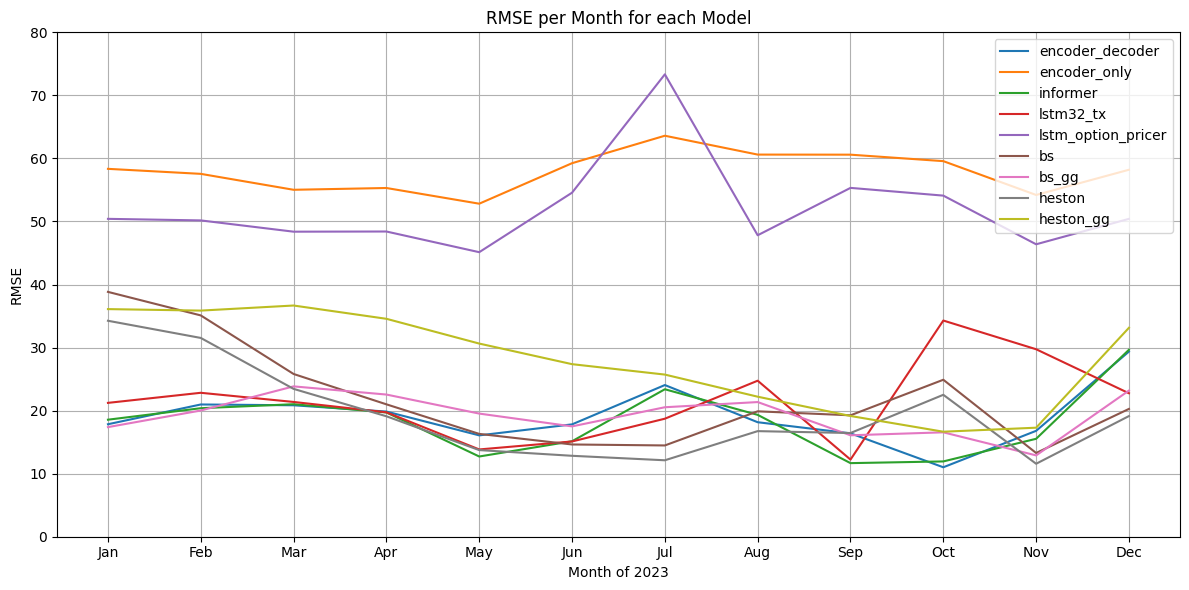

In [106]:
# Plot RMSE per month

chart_month_names = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

models_to_ignore = {"mlp", "mlp_unscaled", "mlp_gg", "mlp_unscaled_gg"}

plt.figure(figsize=(12, 6))

for model_name, rmse_list in rmse_per_month_dict.items():
    if model_name not in models_to_ignore:
        plt.plot(chart_month_names, rmse_list, label=model_name)
    
plt.xlabel("Month of 2023")
plt.ylabel("RMSE")
plt.title("RMSE per Month for each Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 80)
plt.show()

Making a bar chart for training times for each of the trainable models

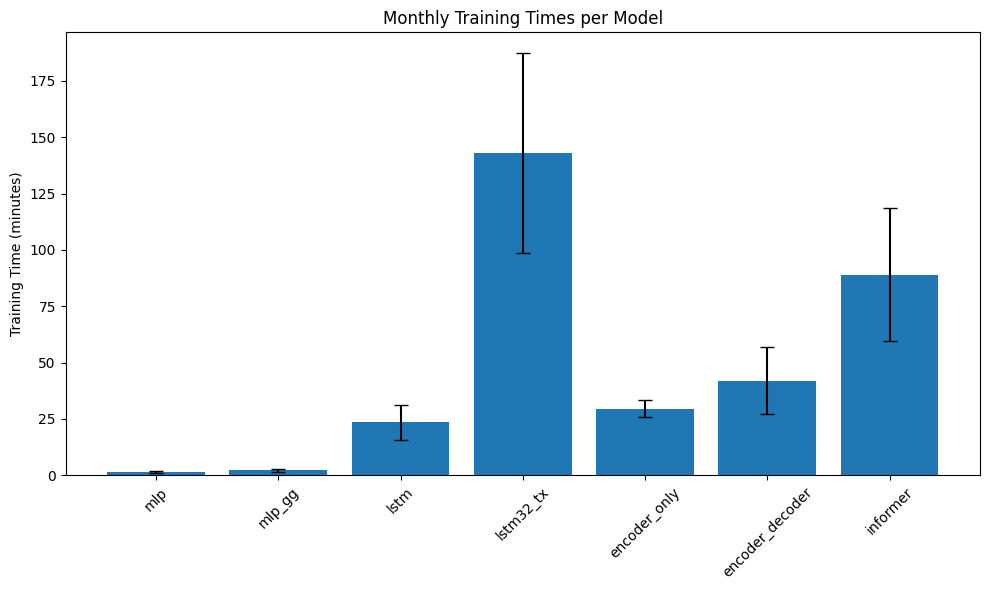

In [107]:
# monthly_training_time_dict

# Rename to take out pimentel
monthly_training_time_dict["mlp"] = monthly_training_time_dict.pop("pimentel_mlp")
monthly_training_time_dict["mlp_gg"] = monthly_training_time_dict.pop("pimentel_mlp_gg")
monthly_training_time_dict["lstm"] = monthly_training_time_dict.pop("lstm_option_pricer")

models = list(monthly_training_time_dict.keys())
models = ['mlp', 'mlp_gg', 'lstm', 'lstm32_tx', 'encoder_only', 'encoder_decoder', 'informer'] # Manually changing order
means = [np.mean(monthly_training_time_dict[m]) for m in models]
stds = [np.std(monthly_training_time_dict[m]) for m in models]

plt.figure(figsize=(10, 6))

plt.bar(models, means, yerr=stds, capsize=5)

plt.xticks(rotation=45, ha="center")
plt.ylabel("Training Time (minutes)")
plt.title("Monthly Training Times per Model")

plt.tight_layout()
plt.show()